In [156]:
# necessary packages
import tensorflow as tf
import pickle

import pandas as pd 
import numpy as np

import os
import sys

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras import optimizers
from keras.utils import to_categorical
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, concatenate
from keras.models import Model
from keras.callbacks import ModelCheckpoint


from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix


In [157]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [158]:
cd '/content/drive/MyDrive/project/'

/content/drive/MyDrive/project


In [159]:
def transformResults(predictions):
    print("""The output here is of the form float, thus we are converting it to binary output based on the following 
condition if a value is > .5 we assign it with 1 and if a value is <.5 we assign it with 0""")
    
    print("\nConverting the ouput to 1D array, and then transformimg the values based on the above condition\n")
    predictions = predictions[:, 0]
    print(f'First 5 values before conversion : {predictions[:5]}')
    
    predictions = [1 if val>0.5 else 0 for val in predictions]
    print(f'First 5 values after the conversion : {predictions[:5]}')
    return predictions

In [160]:
def getResults(y_test, prediction):

    prediction = transformResults(prediction)

    print("\n========== RESULTS ===========\n")
    accuracy = accuracy_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    recall = recall_score(y_test, prediction)

    print(f'Accuracy : {accuracy}\nPrecision : {precision}\nF1_score : {f1}\nRecall : {recall}\n')
    
    print("===== CONFUSION MATRIX =====")
    cf_matrix = confusion_matrix(y_test, prediction)
    print(cf_matrix)
    
    return accuracy, precision, f1, recall

In [161]:
def results_plot(result):
  #Model performance
  accuracy = result.history['acc']
  val_accuracy = result.history['val_acc']
  loss = result.history['loss']
  val_loss = result.history['val_loss']

  epochs = range(5)

  plt.figure(figsize=(15, 5))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, accuracy, label='Training Accuracy')
  plt.plot(epochs, val_accuracy, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Model Accuracy')
  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Model Loss')
  plt.show()

# Image Features

In [162]:
#loading train and test data

with open('train_featuremap.pkl', 'rb') as df_file:
       train_featuremap = pickle.load( df_file)

with open('test_featuremap.pkl', 'rb') as df_file:
       test_featuremap = pickle.load( df_file)


In [163]:
#loading labels
with open('train_labels.pkl', 'rb') as df_file:
       train_labels = pickle.load( df_file)

with open('test_labels.pkl', 'rb') as df_file:
       test_labels = pickle.load( df_file)

In [164]:
# reshape the feature map

train_features = np.array(train_featuremap)
train_features = train_features.reshape((-1,7,7,512))

test_features = np.array(test_featuremap)
test_features = test_features.reshape((-1,7,7,512))


In [165]:

from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, LeakyReLU

def create_model(input_img, input_shape):

  # Build classifier on top of  VGG19
  model = Conv2D(32, (3, 3), padding='same', input_shape=input_shape)(input_img)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D((2, 2),padding='same')(model)
  model = Dropout(0.25)(model)
  
  model = Conv2D(64, (3, 3), padding='same')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  model = Dropout(0.25)(model)
    
  model = Conv2D(128, (3, 3), padding='same')(model)
  model = LeakyReLU(alpha=0.1)(model)
  x = Flatten()(model)
  x = Dense(128, activation='relu')(x)

  return x

In [166]:
# create image input
from keras.layers import Input

input_shape = (7,7,512)

input_img = Input(shape=(7,7,512), name="vgg_input")

image_output = create_model(input_img, input_shape)
image_output

<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense_31')>

In [167]:
#evaluating model on image data

image_output = Dense(16)(image_output)
output = Dense(1, name='output_layer', activation='sigmoid')(image_output)

# To define the model, pass list of input layers
model_cnn_img = Model(inputs=input_img, outputs=output)

model_cnn_img.compile(optimizer=optimizers.RMSprop(lr=1e-3),
              loss='binary_crossentropy',
              metrics=['acc'])

# To fit the model, pass a list of inputs arrays
history = model_cnn_img.fit(x=train_features,y=train_labels,epochs=5,
                    batch_size=16,
                    validation_split=0.2)

Epoch 1/5
207/207 [==============================] - 8s 34ms/step - loss: 0.6852 - acc: 0.5893 - val_loss: 0.6523 - val_acc: 0.6196
Epoch 2/5
207/207 [==============================] - 7s 34ms/step - loss: 0.6568 - acc: 0.6141 - val_loss: 0.6412 - val_acc: 0.6401
Epoch 3/5
207/207 [==============================] - 7s 32ms/step - loss: 0.6348 - acc: 0.6422 - val_loss: 0.6284 - val_acc: 0.6461
Epoch 4/5
207/207 [==============================] - 7s 32ms/step - loss: 0.5985 - acc: 0.6718 - val_loss: 0.6313 - val_acc: 0.6522
Epoch 5/5
207/207 [==============================] - 7s 34ms/step - loss: 0.5672 - acc: 0.7050 - val_loss: 0.6479 - val_acc: 0.6353


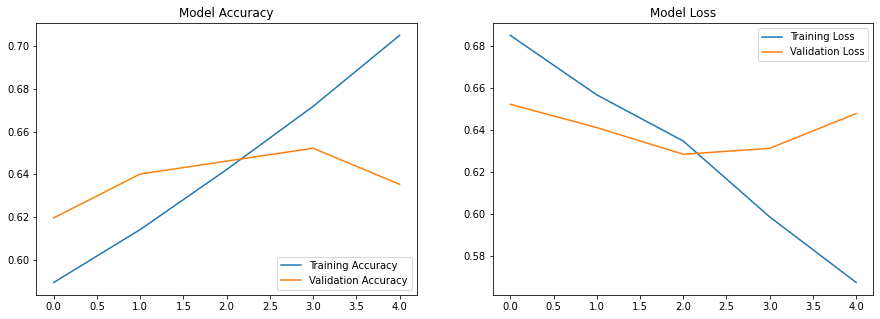

In [168]:
results_plot(history)

In [169]:
#predictions on test data
predictions = model_cnn_img.predict(test_features)

CNN_image_results = getResults(test_labels, predictions)

30/30 [==============================] - 1s 18ms/step
The output here is of the form float, thus we are converting it to binary output based on the following 
condition if a value is > .5 we assign it with 1 and if a value is <.5 we assign it with 0

Converting the ouput to 1D array, and then transformimg the values based on the above condition

First 5 values before conversion : [0.05593283 0.25464746 0.54037404 0.4334172  0.52597207]
First 5 values after the conversion : [0, 0, 1, 0, 1]

========== RESULTS ===========

Accuracy : 0.6201058201058202
Precision : 0.5478260869565217
F1_score : 0.5128900949796472
Recall : 0.48214285714285715

===== CONFUSION MATRIX =====
[[397 156]
 [203 189]]


# Text Features

In [170]:
#loading train and test data

with open('train_features_text.pkl', 'rb') as df_file:
       X_train_t = pickle.load( df_file)

with open('test_features_text.pkl', 'rb') as df_file:
       X_test_t = pickle.load( df_file)

In [171]:
from keras.preprocessing.text import Tokenizer

from keras_preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_t)

X_train_t = tokenizer.texts_to_sequences(X_train_t)
X_test_t = tokenizer.texts_to_sequences(X_test_t)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 50

X_train_t = pad_sequences(X_train_t, padding='post', maxlen=maxlen)
X_test_t= pad_sequences(X_test_t, padding='post', maxlen=maxlen)

In [172]:
cd '/content/drive/MyDrive/project/'

/content/drive/MyDrive/project


In [173]:
from keras.preprocessing.text import Tokenizer

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [174]:
from keras.layers import Flatten, GlobalMaxPooling1D, Conv1D
from keras.layers import Embedding
from keras.layers import Bidirectional,LSTM

def getBidirectionalModel(text_input):
    # Input for variable-length sequences of integers
    # Embedding layer
    x = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(text_input)

    # Add bidirectional LSTMs
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(128))(x)
    
    return x
# create image input
from keras.layers import Input

text_input = Input(shape=(maxlen,))

text_output = getBidirectionalModel(text_input)

In [175]:
from keras.layers import Dense

dense = Dense(16, activation='relu')(text_output)
output = Dense(1, name='output_layer', activation='sigmoid')(dense)

# To define the model, pass list of input layers
model_cnn_text = Model(inputs=text_input, outputs=output)
model_cnn_text.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

# To fit the model, pass a list of inputs arrays
history = model_cnn_text.fit(x=X_train_t,y=train_labels,epochs=5,
                    batch_size=16,
                    validation_split=0.2)

Epoch 1/5
207/207 [==============================] - 56s 238ms/step - loss: 0.5504 - acc: 0.7244 - val_loss: 0.4975 - val_acc: 0.7536
Epoch 2/5
207/207 [==============================] - 47s 228ms/step - loss: 0.4870 - acc: 0.7667 - val_loss: 0.4953 - val_acc: 0.7669
Epoch 3/5
207/207 [==============================] - 47s 229ms/step - loss: 0.4505 - acc: 0.7909 - val_loss: 0.4893 - val_acc: 0.7826
Epoch 4/5
207/207 [==============================] - 51s 247ms/step - loss: 0.4036 - acc: 0.8163 - val_loss: 0.4735 - val_acc: 0.7923
Epoch 5/5
207/207 [==============================] - 48s 232ms/step - loss: 0.3534 - acc: 0.8438 - val_loss: 0.4938 - val_acc: 0.7802


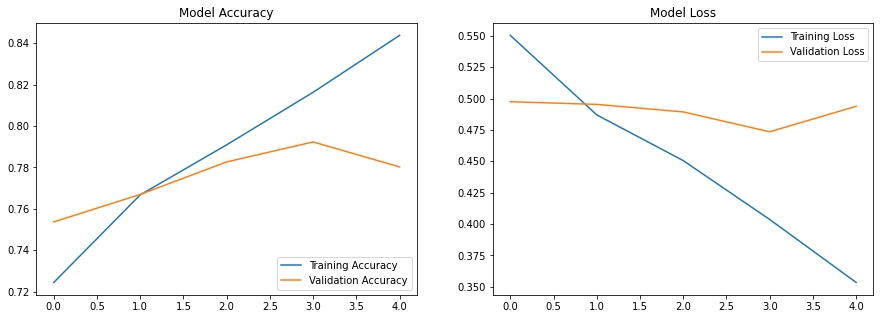

In [176]:
results_plot(history)

In [177]:
#predictions on test data
predictions = model_cnn_text.predict(X_test_t)

CNN_image_results = getResults(test_labels, predictions)

30/30 [==============================] - 5s 108ms/step
The output here is of the form float, thus we are converting it to binary output based on the following 
condition if a value is > .5 we assign it with 1 and if a value is <.5 we assign it with 0

Converting the ouput to 1D array, and then transformimg the values based on the above condition

First 5 values before conversion : [0.02484048 0.01766008 0.6210623  0.21634296 0.95780754]
First 5 values after the conversion : [0, 0, 1, 0, 1]

========== RESULTS ===========

Accuracy : 0.7703703703703704
Precision : 0.7551020408163265
F1_score : 0.7047619047619047
Recall : 0.6607142857142857

===== CONFUSION MATRIX =====
[[469  84]
 [133 259]]


# Image + Text Features

In [178]:
from keras.layers import Dense, Concatenate

# Concatenate the features
concatenate_layer = Concatenate(name='concatenation')([text_output, image_output]) 
output = Dense(1, name='output_layer', activation='sigmoid')(concatenate_layer)

# To define the model, pass list of input layers
model_cnn = Model(inputs=[ text_input, input_img], outputs=output)
model_cnn.compile(optimizer=optimizers.RMSprop(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

# To fit the model, pass a list of inputs arrays
history = model_cnn.fit(x=[ X_train_t, train_features], y=train_labels,epochs=5,
                    batch_size=16,
                    validation_split=0.2)

Epoch 1/5
207/207 [==============================] - 67s 273ms/step - loss: 0.5218 - acc: 0.8731 - val_loss: 0.5495 - val_acc: 0.7778
Epoch 2/5
207/207 [==============================] - 55s 266ms/step - loss: 0.4114 - acc: 0.8882 - val_loss: 0.5089 - val_acc: 0.7778
Epoch 3/5
207/207 [==============================] - 54s 263ms/step - loss: 0.3478 - acc: 0.8843 - val_loss: 0.4965 - val_acc: 0.7742
Epoch 4/5
207/207 [==============================] - 54s 263ms/step - loss: 0.3104 - acc: 0.8876 - val_loss: 0.4945 - val_acc: 0.7814
Epoch 5/5
207/207 [==============================] - 54s 260ms/step - loss: 0.2870 - acc: 0.8894 - val_loss: 0.4972 - val_acc: 0.7850


In [179]:
#predictions on test data
predictions = model_cnn.predict([ X_test_t, test_features])

CNN_multimodal_results = getResults(test_labels,
                                    predictions)

30/30 [==============================] - 5s 121ms/step
The output here is of the form float, thus we are converting it to binary output based on the following 
condition if a value is > .5 we assign it with 1 and if a value is <.5 we assign it with 0

Converting the ouput to 1D array, and then transformimg the values based on the above condition

First 5 values before conversion : [0.01417413 0.021551   0.7582079  0.24927858 0.9162687 ]
First 5 values after the conversion : [0, 0, 1, 0, 1]

========== RESULTS ===========

Accuracy : 0.7671957671957672
Precision : 0.7559523809523809
F1_score : 0.6978021978021978
Recall : 0.6479591836734694

===== CONFUSION MATRIX =====
[[471  82]
 [138 254]]


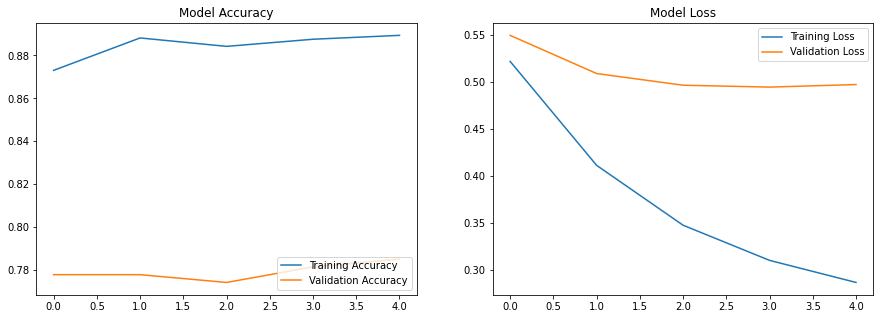

In [180]:
results_plot(history)